In [1]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
import pandas as pd
import numpy as np
from statannot import add_stat_annotation
from umap import UMAP
import hdbscan

/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

In [2]:
from scipy.stats import fisher_exact, chi2_contingency

## Specimen - allele - counts in H5ad


In [3]:
# Gene here are at 100% identity and 80% coverage--effectively alleles
# Given sparseness, this is stored as an h5ad

# Specimen -> Specimen
# catalog_gene -> experimentally recovered allele sequence
# n_detected -> Number of reads assigned to this 
spgc = ad.read_h5ad('data/spgc_summary.h5ad')
spgc

AnnData object with n_obs × n_vars = 455 × 26429922
    obs: 'specimen', 'PRO_GRP', 'Clinical Group'
    layers: 'DPM'

# Next our blast results (diamond blastp)

Known tnaA alleles from KEGG were used as the lure to pull out `catalog_gene` that have a high degree of homology to known tnaA alleles...


In [4]:
blast_res = pd.read_csv(
    "data/Fig04__Tnaa.blast",
    sep='\t',
    names="qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore".split()
)
blast_res

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,eco:b3708,gene_4f5ff9f3_472aa,99.8,472,1,0,1,1416,1,472,1.200000e-274,951.0
1,eco:b3708,gene_da3aa88c_420aa,99.8,420,1,0,1,1260,1,420,1.900000e-243,847.4
2,eco:b3708,gene_a7b3d834_473aa,86.4,471,64,0,1,1413,1,471,3.300000e-240,836.6
3,eco:b3708,gene_bb420ebe_383aa,99.7,383,1,0,268,1416,1,383,1.100000e-222,778.5
4,eco:b3708,gene_ccb28b0e_446aa,60.1,449,173,4,70,1413,1,444,4.700000e-146,523.9
...,...,...,...,...,...,...,...,...,...,...,...,...
8606,nag:AArcMg_0007,gene_8c514af4_371aa,50.1,365,180,2,7,1101,8,370,1.400000e-99,369.4
8607,nas:GCU68_06325,gene_8c514af4_371aa,50.8,364,178,1,7,1098,8,370,3.800000e-97,361.3
8608,psyt:DSAG12_03077,gene_11cc063f_545aa,51.7,536,250,5,31,1617,6,539,1.500000e-156,558.9
8609,psyt:DSAG12_03077,gene_c2a4a551_548aa,51.0,543,257,4,19,1626,2,542,9.900000e-156,556.2


In [5]:
# Given the homology between known alleles many relevant subjects (catalog genes) 
# have multiple hits
# we can just get the best match for each catalog gene based on top bitscore

blast_best_hits = blast_res.sort_values(
    'bitscore', ascending=False
).groupby('sseqid').first()

blast_best_hits.head()

,qseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
sseqid,,,,,,,,,,,
gene_00e33449_460aa,pah:Poras_0335,98.7,460,6,0,1,1380,1,460,2.000000e-266,923.7
gene_011b5cdd_546aa,fpei:C4N17_00935,82.3,542,96,0,4,1629,4,545,2.600000e-273,946.8
gene_061fac30_440aa,aft:BBF96_07640,55.5,431,191,1,88,1380,2,431,2.000000e-141,508.4
gene_064060bb_407aa,beg:INE88_00522,100.0,407,0,0,154,1374,1,407,2.500000e-237,827.0
gene_0671ec75_492aa,clo:HMPREF0868_1596,88.1,454,54,0,7,1368,2,455,1.600000e-246,857.8


<Axes: >

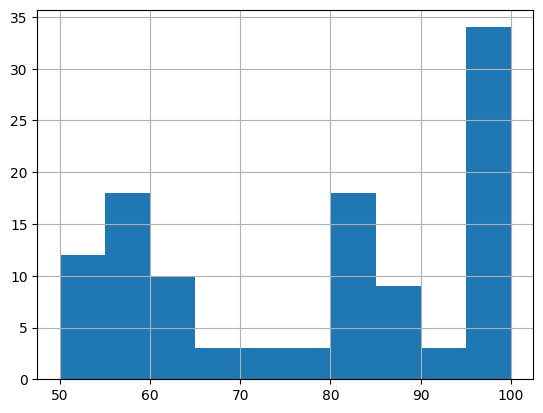

In [6]:
blast_best_hits.pident.hist()

In [7]:
# OK convert into a set.
tnaa_cg = set(blast_best_hits.index)


In [8]:
# Identify which genes are TNAA alleles.
spgc.var['is_tnaa'] = spgc.var.index.map(lambda g: g in tnaa_cg)
spgc.var.is_tnaa.sum()

113

In [9]:
# Slice down to only the tnaa columns
tnaa_spgc = spgc[
    :, spgc.var.is_tnaa
]
# And convert to a true-false matrix...
tnaa_tf_mat = pd.DataFrame(
    (tnaa_spgc.X > 0).todense(),
    index=tnaa_spgc.obs_names,
    columns=tnaa_spgc.var_names
)
tnaa_tf_mat

,gene_40866198_546aa,gene_4f5ff9f3_472aa,gene_84a1f274_463aa,gene_c5693257_479aa,gene_ed8c698f_488aa,gene_011b5cdd_546aa,gene_0671ec75_492aa,gene_1fde9798_460aa,gene_26ccc5d1_437aa,gene_394c216f_483aa,...,gene_36f8929b_404aa,gene_204d29a7_482aa,gene_13a6d79a_459aa,gene_d89a7be8_459aa,gene_7cb24543_461aa,gene_32d6e155_483aa,gene_73e4b578_373aa,gene_6589e4e8_446aa,gene_bb420ebe_383aa,gene_e9e1efd0_483aa
A441BT509,True,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Sample_125021,False,True,False,False,False,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
Sample_125126,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
FB05557591,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
FB05579325,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FB06029449,False,True,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
5140-AL-15,False,False,False,False,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
5140-AL-8,False,False,False,False,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
A980BS164,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# Ok sum up to get the number of alleles per specimen..
tnaa_counts = tnaa_tf_mat.sum(axis=1).to_frame('n_Tnaa')

tnaa_counts_wmd = pd.merge(
    tnaa_counts,
    tnaa_spgc.obs,
    left_index=True,
    right_index=True,
    how='left'
)
tnaa_counts_wmd

,n_Tnaa,specimen,PRO_GRP,Clinical Group
A441BT509,5,A441BT509,Low-PRO,qCD-S
Sample_125021,15,Sample_125021,Unknown,HC
Sample_125126,8,Sample_125126,Unknown,HC
FB05557591,4,FB05557591,Low-PRO,qCD-S
FB05579325,3,FB05579325,Low-PRO,qCD-S
...,...,...,...,...
FB06029449,9,FB06029449,Low-PRO,qCD-S
5140-AL-15,15,5140-AL-15,Unknown,IBS-D
5140-AL-8,11,5140-AL-8,Unknown,IBS-D
A980BS164,12,A980BS164,Low-PRO,qCD-S


/var/folders/jb/3bm1mkxd6pl8cgphbhtsq1bh0000gn/T/ipykernel_12017/3334366449.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

qCD+S v.s. aCD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.861e-02 U_stat=2.480e+02
qCD+S v.s. qCD-S: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.429e-03 U_stat=3.954e+03
qCD+S v.s. HC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.977e-09 U_stat=2.520e+02


/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


qCD+S v.s. IBS-D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.229e-06 U_stat=2.590e+02


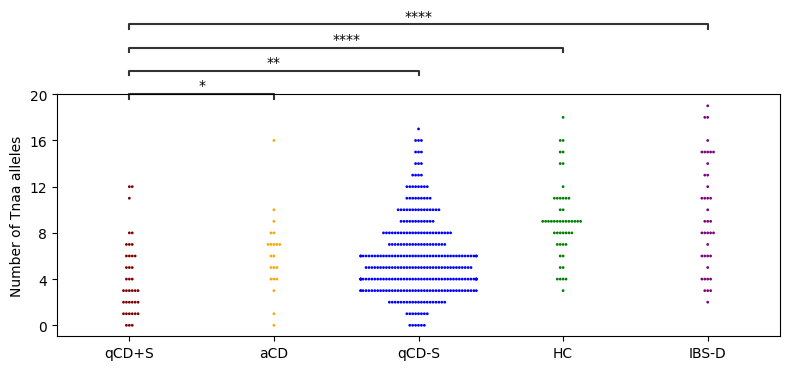

In [11]:
# Figure 4B
fig, ax = plt.subplots(
    figsize=(8,4)
)

sns.swarmplot(
    data=tnaa_counts_wmd,
    x='Clinical Group',
    y='n_Tnaa',
    order=[
        'qCD+S',
        'aCD',
        'qCD-S',
        'HC',
        'IBS-D'
    ],
    ax=ax,
    s=2,
    palette=[
        'maroon',
        'orange',
        'blue',
        'green',
        'purple'
    ]
)
test_results = add_stat_annotation(
    data=tnaa_counts_wmd,
    x='Clinical Group',
    y='n_Tnaa',
    order=[
        'qCD+S',
        'aCD',
        'qCD-S',
        'HC',
        'IBS-D'
    ],
    ax=ax,
    box_pairs=[("qCD+S", "qCD-S"), ("qCD+S", "HC"), ("qCD+S", "IBS-D"), ("qCD+S", "aCD")],
    test='Mann-Whitney', 
    text_format='star',
    loc='outside', verbose=2
)
ax.set_xlabel(None)
ax.set_ylabel("Number of Tnaa alleles")
ax.set_yticks(range(0, 21, 4))
plt.tight_layout()

plt.show()

# Allele Correlation (TF)

To decide on the subsequent analysis, we explored how correlated the presence of tnaa genes are with one another. 
- If mostly non-correlated (i.e., independent) we would proceed with univariate correlations
- If quite correlated, we will proceed with ordination and clustering based approaches

/opt/homebrew/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


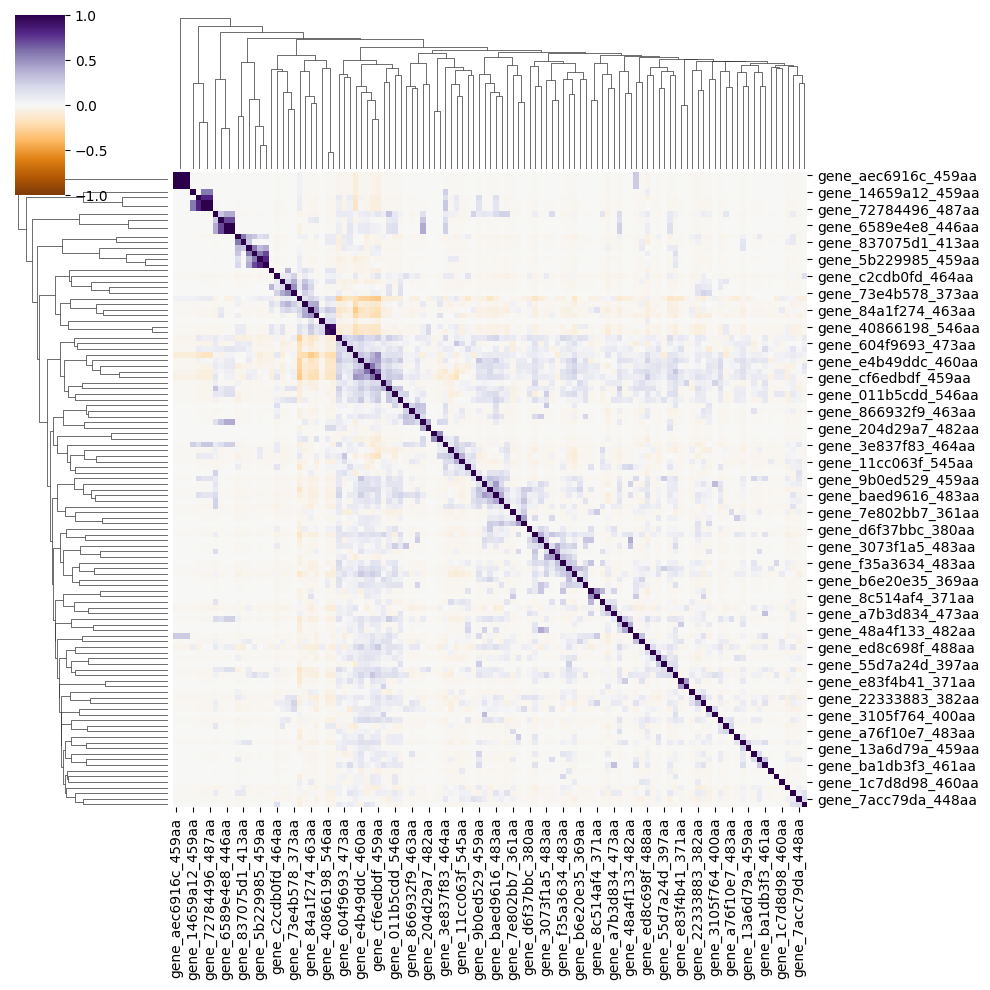

In [28]:
tnaa_corr = tnaa_tf_mat.corr()

sns.clustermap(
    tnaa_corr,
    cmap='PuOr',
    center=0,
    vmin=-1,
    vmax=1,
)

Moderately clustered, so we will proceed with ordination


## Ordination

/opt/homebrew/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


UMAP(angular_rp_forest=True, metric='jaccard', n_neighbors=5, random_state=42, verbose=True)
Tue Oct  3 13:45:23 2023 Construct fuzzy simplicial set
Tue Oct  3 13:45:23 2023 Finding Nearest Neighbors
Tue Oct  3 13:45:24 2023 Finished Nearest Neighbor Search
Disconnection_distance = 1 has removed 39560 edges.  This is not a problem as no vertices were disconnected.
Tue Oct  3 13:45:25 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Oct  3 13:45:26 2023 Finished embedding


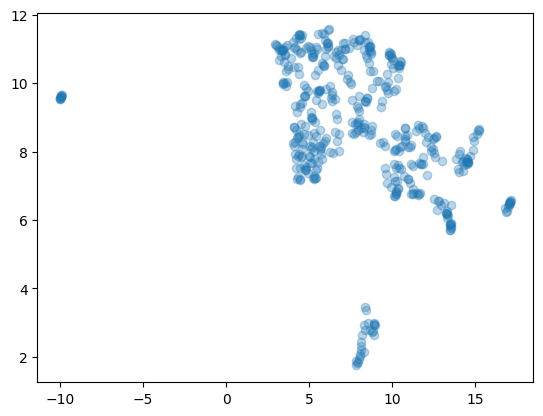

In [12]:
umap_Tnaa = pd.DataFrame(
        UMAP(
            metric='jaccard',
            n_neighbors = 5, 
            min_dist = 0.1, 
            n_components = 2, 
            verbose = True, 
            random_state=42
        ).fit_transform(tnaa_tf_mat),
        index=tnaa_tf_mat.index,
        columns=['X', 'Y']
    )
plt.scatter(
    umap_Tnaa.X,
    umap_Tnaa.Y,
    alpha=0.3
)


In [13]:
umap_Tnaa['cohort'] = umap_Tnaa.index.map(lambda s: "Healthy" if s.startswith("Sample_") else ("IBS" if s.startswith('5140') else "IBD"))
umap_Tnaa.groupby('cohort').count()

,X,Y
cohort,,
Healthy,50,50
IBD,365,365
IBS,40,40


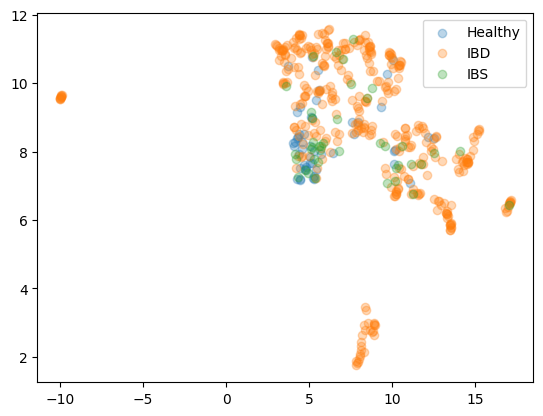

In [14]:
fig, ax = plt.subplots()

for c, c_data in umap_Tnaa.groupby('cohort'):
    ax.scatter(
        c_data.X,
        c_data.Y,
        alpha=0.3,
        label=c
    )
ax.legend()
plt.show()

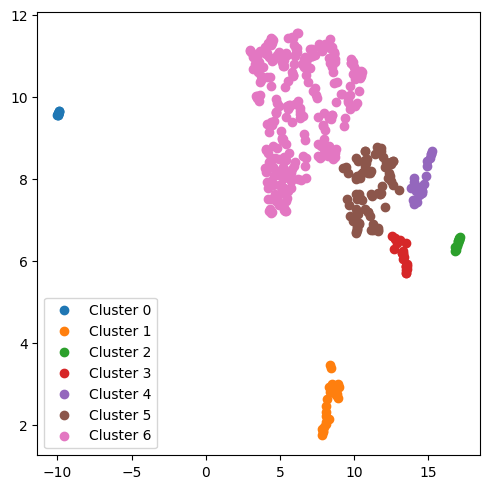

In [20]:
umap_Tnaa['cluster'] = hdbscan.HDBSCAN(
        min_cluster_size=9,
        min_samples=1,
        cluster_selection_epsilon=0.5,
    ).fit_predict(umap_Tnaa[['X', 'Y']])

#umap_Tnaa['cluster'] = AgglomerativeClustering(
#    distance_threshold=20,
#    n_clusters=None
#).fit_predict(
#    umap_Tnaa[['X', 'Y']]
#)

fig, ax = plt.subplots(
    figsize=(5,5)
)

cluster_color = {
    cl: plt.get_cmap('tab10')(cl)
    for cl in umap_Tnaa.cluster.unique()
}
for cluster, c_data in umap_Tnaa[umap_Tnaa.cluster!=-1].groupby('cluster'):
    ax.scatter(
        c_data.X,
        c_data.Y,
        color=cluster_color.get(cluster),
        label=f'Cluster {cluster}'
    )

ax.scatter(
    umap_Tnaa[umap_Tnaa.cluster==-1].X,
    umap_Tnaa[umap_Tnaa.cluster==-1].Y,
    color='grey',
)
ax.legend()

plt.tight_layout()
plt.show()

In [21]:
umap_Tnaa.groupby('cluster').count()

,X,Y,cohort
cluster,,,
0,10,10,10
1,25,25,25
2,12,12,12
3,23,23,23
4,26,26,26
5,78,78,78
6,281,281,281


In [22]:
umap_Tnaa.groupby('cluster').count()

,X,Y,cohort
cluster,,,
0,10,10,10
1,25,25,25
2,12,12,12
3,23,23,23
4,26,26,26
5,78,78,78
6,281,281,281


In [23]:
cohort_cluster_count = umap_Tnaa.groupby(['cohort', 'cluster']).count().reset_index().pivot(
    index='cohort',
    columns='cluster',
    values='X'
).fillna(0).astype(int)


cohort_cluster_count = cohort_cluster_count.loc[[
    'Healthy',
    'IBS',
    'IBD'
]]
cohort_cluster_count

cluster,0,1,2,3,4,5,6
cohort,,,,,,,
Healthy,0,0,0,0,0,6,44
IBS,0,0,1,0,1,11,27
IBD,10,25,11,23,25,61,210


## Interpretation

All of the healthy specimens fall into cluster 5 or 6 (mostly 5). Clusters 0-4 are 'outliers' only found in dysfunctional states (IBD / IBS). So let's assign a name to them, Hxx for healthy and Oxx for outliers:


In [29]:
cluster_names = {
    6: 'H1',
    5: 'H2',
    4: 'O1',
    3: 'O2',
    2: 'O3',
    1: 'O4',
    0: 'O5',
}

In [30]:
GST_color = {
    "H1": 'darkgreen',
    "H2": 'limegreen',
    "O1": 'teal',
    'O2': 'turquoise',
    'O3': 'deepskyblue',
    'O4': 'slategrey',
    'O5': 'maroon'
}

In [35]:
umap_Tnaa_wmd = pd.merge(
    umap_Tnaa,
    tnaa_spgc.obs,
    left_index=True,
    right_index=True,
    how='left'
)
umap_Tnaa_wmd['GST'] = umap_Tnaa_wmd.cluster.apply(cluster_names.get)
umap_Tnaa_wmd['color'] = umap_Tnaa_wmd.GST.apply(GST_color.get)
umap_Tnaa_wmd

,X,Y,cohort,cluster,specimen,PRO_GRP,Clinical Group,GST,color
A441BT509,8.816756,2.749286,IBD,1,A441BT509,Low-PRO,qCD-S,O4,slategrey
Sample_125021,5.396713,9.505709,Healthy,6,Sample_125021,Unknown,HC,H1,darkgreen
Sample_125126,5.189429,10.756545,Healthy,6,Sample_125126,Unknown,HC,H1,darkgreen
FB05557591,6.788433,8.519897,IBD,6,FB05557591,Low-PRO,qCD-S,H1,darkgreen
FB05579325,10.740343,8.690367,IBD,5,FB05579325,Low-PRO,qCD-S,H2,limegreen
...,...,...,...,...,...,...,...,...,...
FB06029449,6.242110,9.909470,IBD,6,FB06029449,Low-PRO,qCD-S,H1,darkgreen
5140-AL-15,5.260756,7.786700,IBS,6,5140-AL-15,Unknown,IBS-D,H1,darkgreen
5140-AL-8,4.205863,7.774515,IBS,6,5140-AL-8,Unknown,IBS-D,H1,darkgreen
A980BS164,4.537179,7.844467,IBD,6,A980BS164,Low-PRO,qCD-S,H1,darkgreen


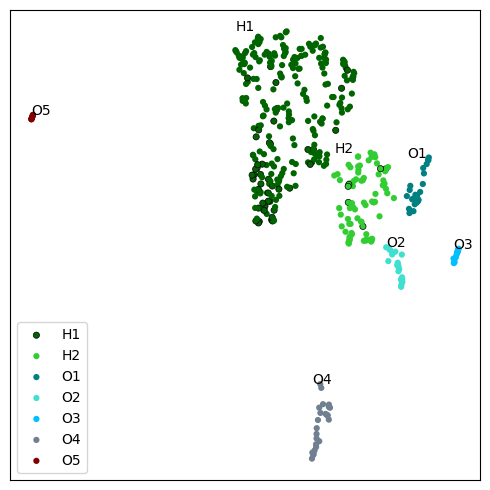

In [41]:
fig, ax = plt.subplots(
    figsize=(5,5)
)

for cluster, c_data in umap_Tnaa_wmd.groupby('GST'):
        ax.scatter(
            c_data.X,
            c_data.Y,
            color=c_data.color,
            label=cluster,
            edgecolor=[
                'k' if c == 'Healthy' else 'None'
                for c in 
                c_data.cohort
            ],
            linewidths=0.5,
            s=20
        )
        ax.annotate(
            cluster,
            (
                c_data.X.min(),
                c_data.Y.max(),
            )
        )
        

ax.legend()
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
#plt.savefig('results/Tnaa_umap_clusters.svg')
plt.show()

In [42]:
cohort_GST_count = umap_Tnaa_wmd.groupby(['cohort', 'GST']).count().reset_index().pivot(
    index='cohort',
    columns='GST',
    values='X'
).fillna(0).astype(int)


cohort_GST_count = cohort_GST_count.loc[[
    'Healthy',
    'IBS',
    'IBD'
]]
cohort_GST_count

GST,H1,H2,O1,O2,O3,O4,O5
cohort,,,,,,,
Healthy,44,6,0,0,0,0,0
IBS,27,11,1,0,1,0,0
IBD,210,61,25,23,11,25,10


In [43]:
PRO_cluster_count = umap_Tnaa_wmd[umap_Tnaa_wmd.cohort == 'IBD'].groupby(['PRO_GRP', 'cluster']).count().reset_index().pivot(
    index='PRO_GRP',
    columns='cluster',
    values='X'
).fillna(0).astype(int)
PRO_cluster_count = PRO_cluster_count.loc[[
    'Low-PRO',
    'High-PRO',
    'Active CD'
]]
PRO_cluster_count

cluster,0,1,2,3,4,5,6
PRO_GRP,,,,,,,
Low-PRO,6,17,6,15,19,55,187
High-PRO,3,4,4,6,6,3,13
Active CD,1,4,1,2,0,3,10


In [44]:
PRO_GST_count = umap_Tnaa_wmd[umap_Tnaa_wmd.cohort == 'IBD'].groupby(['PRO_GRP', 'GST']).count().reset_index().pivot(
    index='PRO_GRP',
    columns='GST',
    values='X'
).fillna(0).astype(int)
PRO_GST_count = PRO_GST_count.loc[[
    'Low-PRO',
    'High-PRO',
    'Active CD'
]]
PRO_GST_count

GST,H1,H2,O1,O2,O3,O4,O5
PRO_GRP,,,,,,,
Low-PRO,187,55,19,15,6,17,6
High-PRO,13,3,6,6,4,4,3
Active CD,10,3,0,2,1,4,1


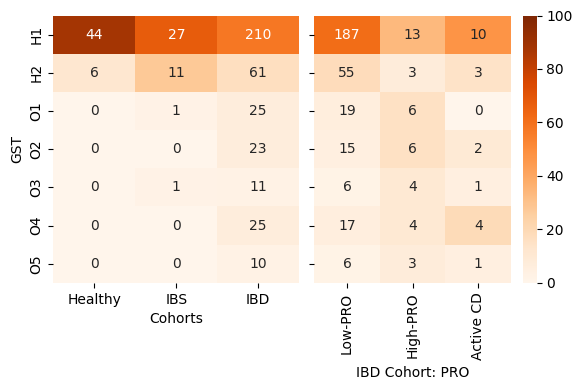

In [45]:
fig, axes = plt.subplots(
    ncols=2,
    figsize=(6,4),
    sharey=True,
)

sns.heatmap(
    data=(cohort_GST_count.T / cohort_GST_count.sum(axis=1) * 100),
    cmap='Oranges',
    vmin=0,
    vmax=100,
    ax=axes[0],
    annot=cohort_GST_count.T,
    fmt='d',
    cbar=False
)

axes[0].set_xlabel("Cohorts")

sns.heatmap(
    data=(PRO_GST_count.T / PRO_GST_count.sum(axis=1) * 100),
    cmap='Oranges',
    vmin=0,
    vmax=100,
    ax=axes[1],
    annot=PRO_GST_count.T,
    fmt='d'
)
axes[1].set_ylabel(None)
axes[1].set_xlabel("IBD Cohort: PRO")
plt.tight_layout()
#plt.savefig('results/Tnaa_GST_counts.svg')
plt.show()

<Axes: xlabel='cluster', ylabel='PRO_GRP'>

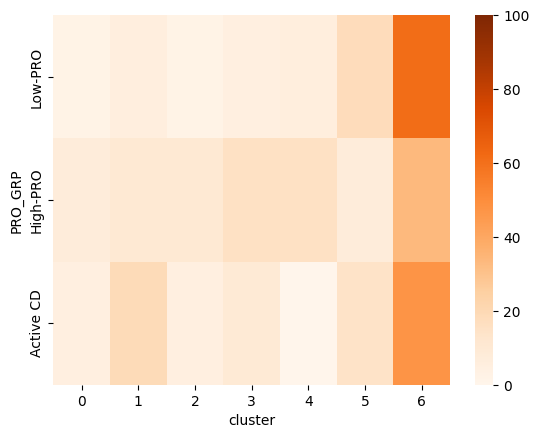

In [46]:
sns.heatmap(
    data=(PRO_cluster_count.T / PRO_cluster_count.sum(axis=1) * 100).T,
    cmap='Oranges',
    vmin=0,
    vmax=100
)

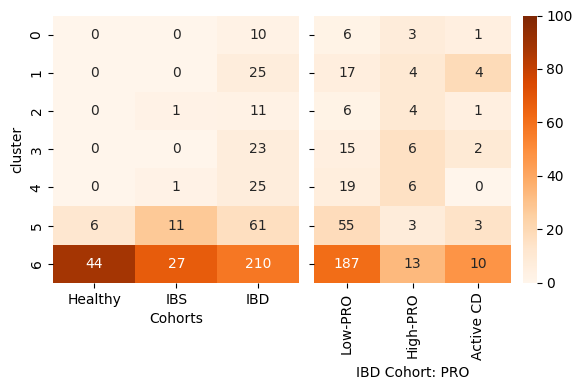

In [47]:
fig, axes = plt.subplots(
    ncols=2,
    figsize=(6,4),
    sharey=True,
)

sns.heatmap(
    data=(cohort_cluster_count.T / cohort_cluster_count.sum(axis=1) * 100),
    cmap='Oranges',
    vmin=0,
    vmax=100,
    ax=axes[0],
    annot=cohort_cluster_count.T,
    fmt='d',
    cbar=False
)

axes[0].set_xlabel("Cohorts")

sns.heatmap(
    data=(PRO_cluster_count.T / PRO_cluster_count.sum(axis=1) * 100),
    cmap='Oranges',
    vmin=0,
    vmax=100,
    ax=axes[1],
    annot=PRO_cluster_count.T,
    fmt='d'
)
axes[1].set_ylabel(None)
axes[1].set_xlabel("IBD Cohort: PRO")
plt.tight_layout()
#plt.savefig('results/Tnaa_cluster_counts.svg')
plt.show()


In [48]:
cohort_GST_count

GST,H1,H2,O1,O2,O3,O4,O5
cohort,,,,,,,
Healthy,44,6,0,0,0,0,0
IBS,27,11,1,0,1,0,0
IBD,210,61,25,23,11,25,10


In [49]:
chi2_contingency(
    cohort_cluster_count
)

Chi2ContingencyResult(statistic=30.379274423536295, pvalue=0.0024476334282723315, dof=12, expected_freq=array([[  1.0989011 ,   2.74725275,   1.31868132,   2.52747253,
          2.85714286,   8.57142857,  30.87912088],
       [  0.87912088,   2.1978022 ,   1.05494505,   2.02197802,
          2.28571429,   6.85714286,  24.7032967 ],
       [  8.02197802,  20.05494505,   9.62637363,  18.45054945,
         20.85714286,  62.57142857, 225.41758242]]))

In [50]:
chi2_contingency(
    PRO_cluster_count
)

Chi2ContingencyResult(statistic=38.03906609249393, pvalue=0.0001513186771239136, dof=12, expected_freq=array([[  8.35616438,  20.89041096,   9.19178082,  19.21917808,
         20.89041096,  50.97260274, 175.47945205],
       [  1.06849315,   2.67123288,   1.17534247,   2.45753425,
          2.67123288,   6.51780822,  22.43835616],
       [  0.57534247,   1.43835616,   0.63287671,   1.32328767,
          1.43835616,   3.50958904,  12.08219178]]))

In [51]:
umap_Tnaa_wmd['SuperGST'] = umap_Tnaa_wmd.GST.apply(lambda g: g[0])

In [52]:
cohort_SuperGST_count = umap_Tnaa_wmd.groupby(['cohort', 'SuperGST']).count().reset_index().pivot(
    index='cohort',
    columns='SuperGST',
    values='X'
).fillna(0).astype(int)


cohort_SuperGST_count = cohort_SuperGST_count.loc[[
    'Healthy',
    'IBS',
    'IBD'
]]
cohort_SuperGST_count

SuperGST,H,O
cohort,,
Healthy,50,0
IBS,38,2
IBD,271,94


In [55]:
# Quite significant skew by cohort
chi2_contingency(
    cohort_SuperGST_count
)

Chi2ContingencyResult(statistic=24.34798849067043, pvalue=5.162992290260727e-06, dof=2, expected_freq=array([[ 39.45054945,  10.54945055],
       [ 31.56043956,   8.43956044],
       [287.98901099,  77.01098901]]))

In [53]:
PRO_SuperGST_count = umap_Tnaa_wmd[umap_Tnaa_wmd.cohort == 'IBD'].groupby(['PRO_GRP', 'SuperGST']).count().reset_index().pivot(
    index='PRO_GRP',
    columns='SuperGST',
    values='X'
).fillna(0).astype(int)
PRO_SuperGST_count = PRO_SuperGST_count.loc[[
    'Low-PRO',
    'High-PRO',
    'Active CD'
]]
PRO_SuperGST_count

SuperGST,H,O
PRO_GRP,,
Low-PRO,242,63
High-PRO,16,23
Active CD,13,8


In [56]:
chi2_contingency(
    PRO_SuperGST_count
)
# Likewise, symptoms quite closely correlate to being in an outlier grouping of alleles

Chi2ContingencyResult(statistic=28.32805310655436, pvalue=7.057346264874676e-07, dof=2, expected_freq=array([[226.45205479,  78.54794521],
       [ 28.95616438,  10.04383562],
       [ 15.59178082,   5.40821918]]))

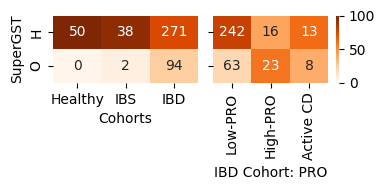

In [57]:
fig, axes = plt.subplots(
    ncols=2,
    figsize=(4,2),
    sharey=True,
)

sns.heatmap(
    data=(cohort_SuperGST_count.T / cohort_SuperGST_count.sum(axis=1) * 100),
    cmap='Oranges',
    vmin=0,
    vmax=100,
    ax=axes[0],
    annot=cohort_SuperGST_count.T,
    fmt='d',
    cbar=False
)

axes[0].set_xlabel("Cohorts")

sns.heatmap(
    data=(PRO_SuperGST_count.T / PRO_SuperGST_count.sum(axis=1) * 100),
    cmap='Oranges',
    vmin=0,
    vmax=100,
    ax=axes[1],
    annot=PRO_SuperGST_count.T,
    fmt='d'
)
axes[1].set_ylabel(None)
axes[1].set_xlabel("IBD Cohort: PRO")
plt.tight_layout()
#plt.savefig('results/Tnaa_SuperGST_counts.svg')
plt.show()

In [58]:
umap_Tnaa_wmd['Clinical Group'] = umap_Tnaa_wmd.apply(
    lambda r: r.cohort if r.cohort != 'IBD' else r.PRO_GRP, axis=1
)

umap_Tnaa_wmd

,X,Y,cohort,cluster,specimen,PRO_GRP,Clinical Group,GST,color,SuperGST
A441BT509,8.816756,2.749286,IBD,1,A441BT509,Low-PRO,Low-PRO,O4,slategrey,O
Sample_125021,5.396713,9.505709,Healthy,6,Sample_125021,Unknown,Healthy,H1,darkgreen,H
Sample_125126,5.189429,10.756545,Healthy,6,Sample_125126,Unknown,Healthy,H1,darkgreen,H
FB05557591,6.788433,8.519897,IBD,6,FB05557591,Low-PRO,Low-PRO,H1,darkgreen,H
FB05579325,10.740343,8.690367,IBD,5,FB05579325,Low-PRO,Low-PRO,H2,limegreen,H
...,...,...,...,...,...,...,...,...,...,...
FB06029449,6.242110,9.909470,IBD,6,FB06029449,Low-PRO,Low-PRO,H1,darkgreen,H
5140-AL-15,5.260756,7.786700,IBS,6,5140-AL-15,Unknown,IBS,H1,darkgreen,H
5140-AL-8,4.205863,7.774515,IBS,6,5140-AL-8,Unknown,IBS,H1,darkgreen,H
A980BS164,4.537179,7.844467,IBD,6,A980BS164,Low-PRO,Low-PRO,H1,darkgreen,H


/var/folders/jb/3bm1mkxd6pl8cgphbhtsq1bh0000gn/T/ipykernel_12017/1102021266.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(
/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 23.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/jb/3bm1mkxd6pl8cgphbhtsq1bh0000gn/T/ipykernel_12017/1102021266.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes['n_allele'].set_yticklabels(
/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 28.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 28.9% of the points cannot be placed; you may want to decrease the size of the markers or use strippl

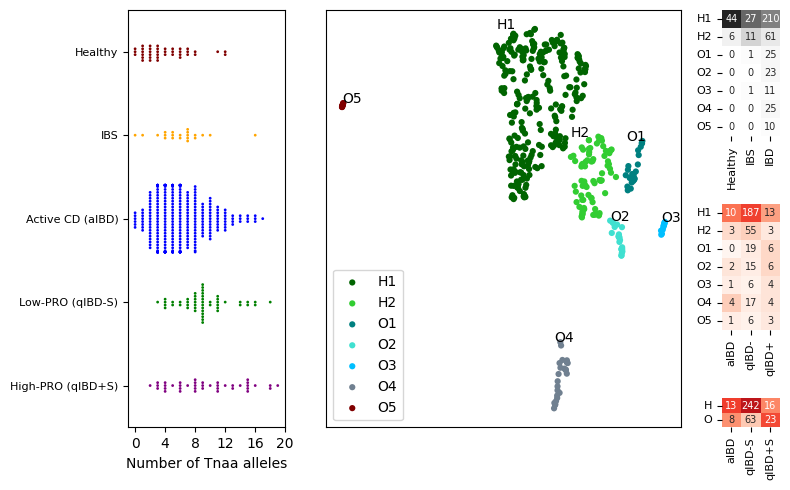

In [63]:
fig, axes = plt.subplot_mosaic(
    [
        ['n_allele', 'n_allele', 'umap',  'umap', 'umap',  'umap', 'gst_all', ],
        ['n_allele', 'n_allele', 'umap',  'umap', 'umap',  'umap', 'gst_all', ],
        ['n_allele', 'n_allele', 'umap',  'umap', 'umap',  'umap', 'gst_ibd', ],
        ['n_allele', 'n_allele', 'umap',  'umap', 'umap',  'umap', 'gst_ibd', ],        
        ['n_allele', 'n_allele', 'umap',  'umap', 'umap',  'umap', 'supergst', ],
    ],
    figsize=(8,5)
)
# --
sns.swarmplot(
    data=tnaa_counts_wmd,
    y='Clinical Group',
    x='n_Tnaa',

    order=[
        'qCD+S',
        'aCD',
        'qCD-S',
        'HC',
        'IBS-D'
    ],
    ax=axes['n_allele'],
    s=2,
    palette=[
        'maroon',
        'orange',
        'blue',
        'green',
        'purple'
    ]
)

axes['n_allele'].set_ylabel(None)
axes['n_allele'].set_xlabel("Number of Tnaa alleles")
axes['n_allele'].set_xticks(range(0, 21, 4))
axes['n_allele'].set_yticklabels(
    [
        'Healthy',
        'IBS',
        'Active CD (aIBD)',
        'Low-PRO (qIBD-S)',
        'High-PRO (qIBD+S)'
    ],
    fontsize=8,
    rotation=0,
)
# --


for cluster, c_data in umap_Tnaa_wmd.groupby('GST'):
        axes['umap'].scatter(
            c_data.X,
            c_data.Y,
            color=c_data.color,
            label=cluster,
            edgecolor=[
                'k' if c == 'HC' else 'red' if c == 'qCD+S' else "None"
                for c in 
                c_data['Clinical Group']
            ],
            linewidths=1,
            s=20,
            #alpha=0.8,
        )
        axes['umap'].annotate(
            cluster,
            (
                c_data.X.min(),
                c_data.Y.max(),
            )
        )        
        

axes['umap'].legend()
axes['umap'].set_xticks([])
axes['umap'].set_yticks([])
# --
sns.heatmap(
    data=(cohort_GST_count.T / cohort_GST_count.sum(axis=1) * 100)[[
        'Healthy',
        'IBS',
        'IBD',
    ]],
    cmap='Greys',
    vmin=0,
    vmax=100,
    ax=axes['gst_all'],
    annot=cohort_GST_count.T[[
        'Healthy',
        'IBS',
        'IBD',
    ]],
    fmt='d',
    cbar=False,
    annot_kws={
        'fontsize': 7,
    },
    
)

axes["gst_all"].set_xlabel(None)
axes["gst_all"].set_ylabel(None)
axes["gst_all"].set_xticklabels(
    [
        'Healthy',
        'IBS',
        'IBD'
    ],
    fontsize=8,
)
axes["gst_all"].set_yticklabels(
    [
        'H1',
        'H2',
        'O1',
        'O2',
        'O3',
        'O4',
        'O5'
    ],
    fontsize=8,
    rotation=0,
)

sns.heatmap(
    data=(PRO_GST_count.T / PRO_GST_count.sum(axis=1) * 100)[[
        'Active CD',
        'Low-PRO',
        'High-PRO'
    ]],
    cmap='Reds',
    vmin=0,
    vmax=100,
    ax=axes["gst_ibd"],
    annot=PRO_GST_count.T[[
        'Active CD',
        'Low-PRO',
        'High-PRO'
    ]],
    fmt='d',
    cbar=False,
    annot_kws={
        'fontsize': 7,
    },
)
axes["gst_ibd"].set_xlabel(None)
axes["gst_ibd"].set_ylabel(None)
axes["gst_ibd"].set_xticklabels(
    [
        'aIBD',
        'qIBD-',
        'qIBD+'
    ],
    fontsize=8,
)
axes["gst_ibd"].set_yticklabels(
    [
        'H1',
        'H2',
        'O1',
        'O2',
        'O3',
        'O4',
        'O5'
    ],
    fontsize=8,
    rotation=0,
)
# --
sns.heatmap(
    data=(PRO_SuperGST_count.T / PRO_SuperGST_count.sum(axis=1) * 100)[[
        'Active CD',
        'Low-PRO',
        'High-PRO'
    ]],
    cmap='Reds',
    vmin=0,
    vmax=100,
    ax=axes['supergst'],
    annot=PRO_SuperGST_count.T[[
        'Active CD',
        'Low-PRO',
        'High-PRO'
    ]],
    fmt='d',
    cbar=None,
    annot_kws={
        'fontsize': 7,
    },
)
axes['supergst'].set_ylabel(None)
axes['supergst'].set_xlabel(None)
axes['supergst'].set_xticklabels(
    [
        'aIBD',
        'qIBD-S',
        'qIBD+S'
    ],
    fontsize=8,
)
axes['supergst'].set_yticklabels(
    [
        'H',
        'O',
    ],
    fontsize=8,
    rotation=0,
)
plt.tight_layout()
#plt.savefig('results/Tnaa_umap_clusters_count_combined.svg')
plt.show()